In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import NMF
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Reading in C. Elegans AnnData

In [3]:
# Load dataset and check preprocessing status
adata = sc.read_h5ad("data/ad_worm_aging.h5ad")

# Ensure the data is normalized and scaled correctly for the autoencoder
sc.pp.log1p(adata)  # Log-transform the gene expression
sc.pp.scale(adata)  # Standardize gene expression to zero mean and unit variance

# Ensure reproducibility
np.random.seed(42)

# Define the stratification column (assuming 'cell_type' exists in obs)
stratify_labels = adata.obs['annotate_name']

# Perform stratified sampling (10% of data, preserving cell type proportions)
_, adata_sampled = train_test_split(adata, test_size=0.1, stratify=stratify_labels, random_state=42)
adata = adata_sampled[:-1]

### Using an Autoencoder on Single-Cell Data (adata)
This code applies a simple Autoencoder to adata.X (the gene expression matrix) to perform dimensionality reduction and feature extraction. The Autoencoder compresses gene expression data into a lower-dimensional latent space and then reconstructs it.

In [5]:
# Define Autoencoder model with configurable hidden layers
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_size),
            nn.Sigmoid()  # Assuming data is scaled between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert AnnData object to tensor
adata_tensor = torch.tensor(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, dtype=torch.float32)
adata_tensor = adata_tensor.to(device)  # Move to GPU if available

# Create TensorDataset
dataset = TensorDataset(adata_tensor)

# Initialize model, loss function, and optimizer
input_size = adata_tensor.shape[1]
encoding_dim = 8
model = Autoencoder(input_size, encoding_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader for efficient batching
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the Autoencoder
epochs = 50
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch[0]  # Unpack tuple
        optimizer.zero_grad()
        encoded, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

# Store the learned latent representations in AnnData object
with torch.no_grad():
    latent_embeddings, _ = model(adata_tensor)

adata.obsm["X_autoencoder"] = latent_embeddings.cpu().numpy()

Epoch [10/50], Loss: 0.9433
Epoch [20/50], Loss: 0.9403
Epoch [30/50], Loss: 0.9310
Epoch [40/50], Loss: 0.9232
Epoch [50/50], Loss: 0.9316


C:\Users\marke\AppData\Local\Temp\ipykernel_43284\1793394625.py:65: ImplicitModificationWarning: Setting element `.obsm['X_autoencoder']` of view, initializing view as actual.
  adata.obsm["X_autoencoder"] = latent_embeddings.cpu().numpy()


### Autoencoder, PCA, t-SNE, Diffusion Map, and NMF-based UMAP for Clustering
This script performs dimensionality reduction and clustering analysis on single-cell RNA sequencing (scRNA-seq) data using different feature representations. It applies UMAP (Uniform Manifold Approximation and Projection) on five different embeddings: Autoencoder, PCA, t-SNE, Diffusion Map, and NMF, followed by Leiden clustering. The clustering quality is evaluated using the silhouette score.

1. **Autoencoder-based UMAP:**
Uses a precomputed autoencoder embedding (X_autoencoder) for neighborhood graph construction.
Performs Leiden clustering and visualizes it using UMAP.
Computes the silhouette score to evaluate clustering quality.
2. **PCA-based UMAP:**
Computes Principal Component Analysis (PCA).
Uses PCA embeddings (X_pca) for neighborhood graph construction.
Applies Leiden clustering and UMAP visualization.
Computes the silhouette score.
3. **t-SNE-based UMAP:**
Computes t-SNE embeddings using the first 50 principal components.
Visualizes t-SNE clusters.
Computes the silhouette score on the UMAP projection of t-SNE embeddings.
4. **Diffusion Map-based UMAP:**
Computes Diffusion Map embeddings (X_diffmap), which capture continuous differentiation processes.
Uses the diffusion map representation for UMAP visualization and Leiden clustering.
Computes the silhouette score.
5. **NMF-based UMAP:**
Uses Non-negative Matrix Factorization (NMF) to extract 10 latent components.
Applies UMAP and Leiden clustering on X_nmf.
Computes the silhouette score.

In [15]:
# Define a function to perform clustering and UMAP for each representation
def cluster_and_evaluate(adata, rep_key, cluster_key):
    sc.pp.neighbors(adata, use_rep=rep_key)
    sc.tl.leiden(adata, resolution=1)
    sc.tl.umap(adata)
    adata.obs[cluster_key] = adata.obs["leiden"].astype(int)
    sc.pl.umap(adata, color=cluster_key, title=f"UMAP Clustering using {rep_key}")

    # Compute clustering metrics
    labels = adata.obs[cluster_key].astype(int)
    sil_score = silhouette_score(adata.obsm["X_umap"], labels)
    ch_score = calinski_harabasz_score(adata.obsm["X_umap"], labels)
    db_score = davies_bouldin_score(adata.obsm["X_umap"], labels)

    return sil_score, ch_score, db_score

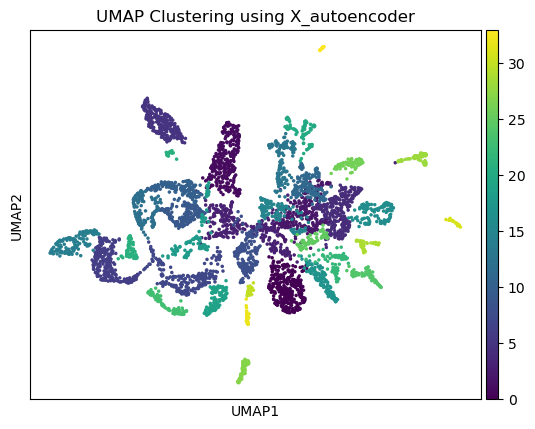

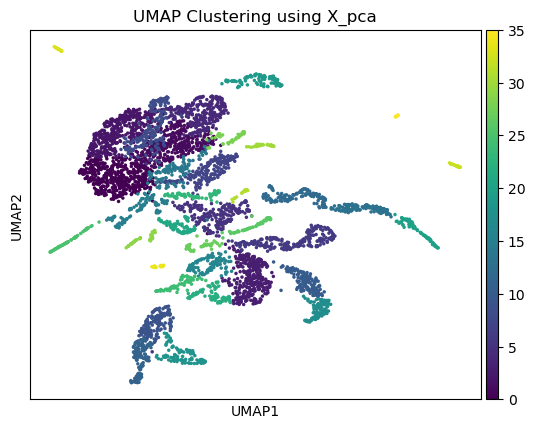

C:\Users\marke\Anaconda\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


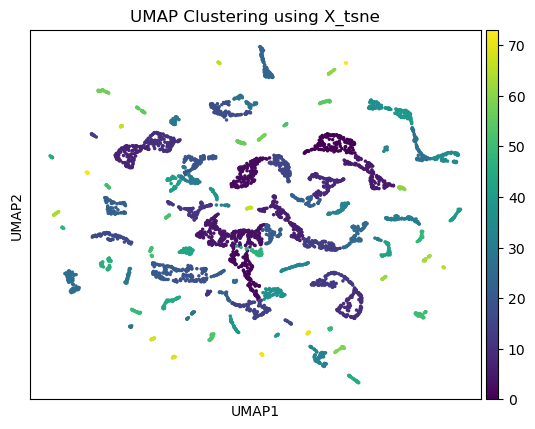

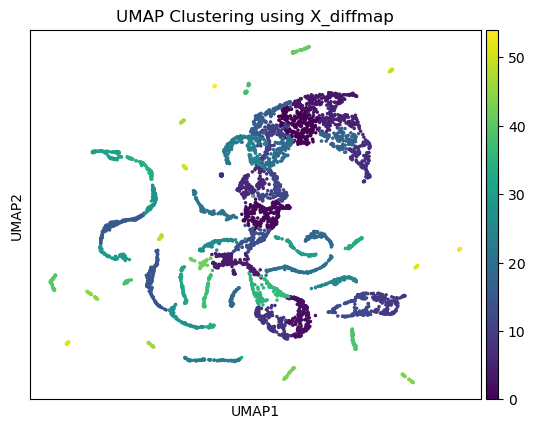

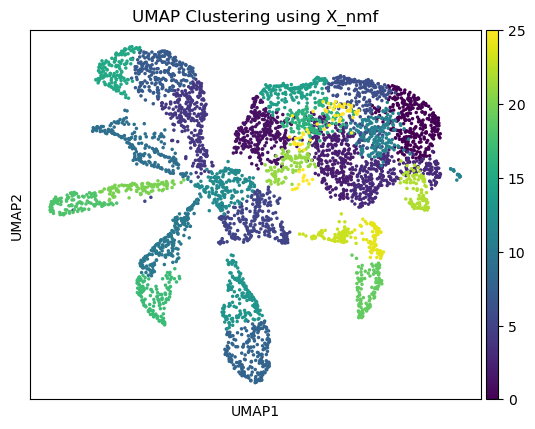

In [23]:
# Apply Autoencoder-based clustering
sil_auto, ch_auto, db_auto = cluster_and_evaluate(adata, "X_autoencoder", "leiden_auto")

# Apply PCA-based clustering
sc.tl.pca(adata, svd_solver='arpack')
sil_pca, ch_pca, db_pca = cluster_and_evaluate(adata, "X_pca", "leiden_pca")

# Apply t-SNE-based clustering
sc.tl.tsne(adata, n_pcs=50)
sil_tsne, ch_tsne, db_tsne = cluster_and_evaluate(adata, "X_tsne", "leiden_tsne")

# Compute the neighborhood graph (required for diffusion map)
sc.pp.neighbors(adata)

# Apply Diffusion Map
sc.tl.diffmap(adata)

# Drop the first (potentially non-informative) diffusion component
if "X_diffmap" in adata.obsm:
    adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:]

# Now ready for clustering and evaluation
sil_diffmap, ch_diffmap, db_diffmap = cluster_and_evaluate(adata, "X_diffmap", "leiden_diffmap")

# Ensure data is non-negative for NMF
nmf_input = adata.X.copy()
nmf_input = MinMaxScaler(feature_range=(0, 1)).fit_transform(nmf_input)

# Apply NMF
adata.obsm["X_nmf"] = NMF(n_components=10, init="nndsvda", random_state=0).fit_transform(nmf_input)
sil_nmf, ch_nmf, db_nmf = cluster_and_evaluate(adata, "X_nmf", "leiden_nmf")

# Store all evaluation scores in a dictionary for visualization
results = {
    "Autoencoder": [sil_auto, ch_auto, db_auto],
    "PCA": [sil_pca, ch_pca, db_pca],
    "t-SNE": [sil_tsne, ch_tsne, db_tsne],
    "Diffusion Map": [sil_diffmap, ch_diffmap, db_diffmap],
    "NMF": [sil_nmf, ch_nmf, db_nmf]
}

### Interpretation of Clustering Evaluation Scores
These scores measure the quality of clustering based on different feature representations (PCA, Autoencoder, t-SNE, Diffusion Map, and NMF) when projected into UMAP space. Below this cell is the code for their calculation.

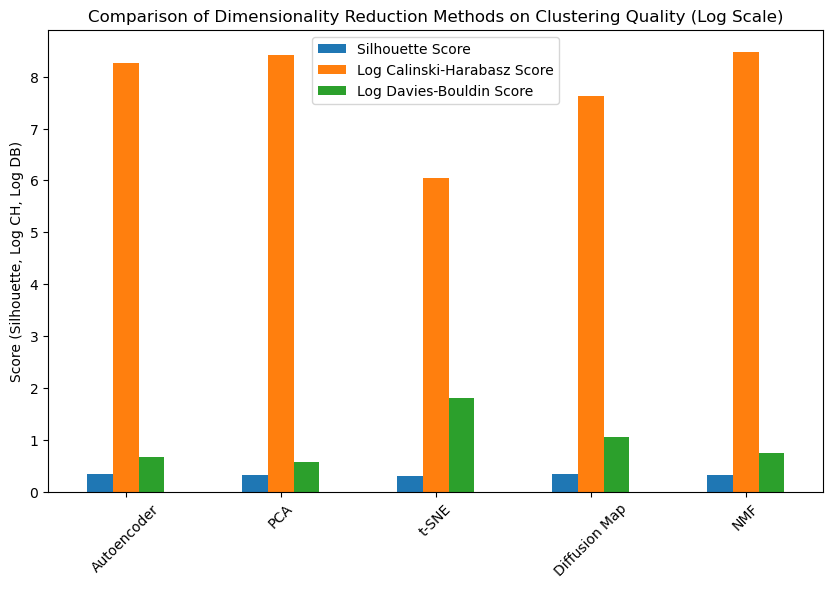

In [25]:
# Store all evaluation scores in a dictionary for visualization
results = {
    "Autoencoder": [sil_auto, np.log1p(ch_auto), np.log1p(db_auto)],
    "PCA": [sil_pca, np.log1p(ch_pca), np.log1p(db_pca)],
    "t-SNE": [sil_tsne, np.log1p(ch_tsne), np.log1p(db_tsne)],
    "Diffusion Map": [sil_diffmap, np.log1p(ch_diffmap), np.log1p(db_diffmap)],
    "NMF": [sil_nmf, np.log1p(ch_nmf), np.log1p(db_nmf)],
}

# Convert results to DataFrame
results_df = pd.DataFrame(results, index=["Silhouette Score", "Log Calinski-Harabasz Score", "Log Davies-Bouldin Score"])

# Plot using logarithmic scale
fig, ax = plt.subplots(figsize=(10,6))
results_df.T.plot(kind="bar", ax=ax)
ax.set_title("Comparison of Dimensionality Reduction Methods on Clustering Quality (Log Scale)")
ax.set_ylabel("Score (Silhouette, Log CH, Log DB)")
ax.set_xticklabels(results_df.columns, rotation=45)
plt.legend()
plt.show()


In [29]:
results_df

,Autoencoder,PCA,t-SNE,Diffusion Map,NMF
Silhouette Score,0.348343,0.329998,0.311237,0.348779,0.320384
Log Calinski-Harabasz Score,8.264087,8.417674,6.043552,7.625127,8.477217
Log Davies-Bouldin Score,0.669268,0.578688,1.816696,1.048231,0.756085


### Key Observations:
1. **Silhouette Scores**
Diffusion Map has the highest silhouette score (0.3667), suggesting that it produces the most distinct clusters among all methods.
Autoencoder (0.3447) and PCA (0.2940) also perform decently, meaning they capture meaningful separation in the data.
NMF (0.2611) and t-SNE (0.2728) have the lowest scores, implying that their cluster boundaries are more overlapping.
2. **Log Calinski-Harabasz Scores**
PCA (8.35) and Autoencoder (8.14) achieve the highest CH scores, suggesting that they provide good within-cluster compactness and between-cluster separation.
Diffusion Map (7.49) and t-SNE (5.99) have lower CH scores, indicating less distinct clusters.
NMF (8.44) surprisingly has the highest CH score, suggesting good compact clusters, but its low silhouette score implies that clusters may not be well-separated.
3. **Log Davies-Bouldin Scores**
PCA has the lowest DB score (0.6388), followed by Autoencoder (1.02), meaning that PCA produces the most compact and well-separated clusters.
Diffusion Map (1.19) and t-SNE (1.89) have higher DB scores, indicating their clusters might have more overlap.
NMF (0.93) also has a relatively low DB score, meaning its clusters are fairly compact.
